# Are contact counts overdispered?

In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pastis import dispersion

/usr/share/miniconda3/envs/pastisnb/lib/python3.9/site-packages/pastis/externals/iced/normalization/_ca_utils.py:8: UserWarning: The API of this module is likely to change. Use only for testing purposes
  warnings.warn(
/usr/share/miniconda3/envs/pastisnb/lib/python3.9/site-packages/iced/normalization/_ca_utils.py:8: UserWarning: The API of this module is likely to change. Use only for testing purposes
  warnings.warn(
/usr/share/miniconda3/envs/pastisnb/lib/python3.9/site-packages/pastis/fastio.py:7: UserWarning: The module pastis.fastio is deprecated. The packaged iced has identical features and should be used instead. This module will be removed in version 0.5
  warnings.warn(


In [2]:
from pastis import fastio
from iced import io
import iced

def load(filename, normalize=True, bias=None):
    try:
        lengths = io.load_lengths(filename.replace(".matrix", ".bed"))
    except IOError:
        lengths = io.load_lengths(filename.replace(".matrix", "_abs.bed"))

    counts = io.load_counts(filename, lengths=lengths)

    # Remove the diagonal and remove 0 from matrix
    counts.setdiag(0)
    counts = counts.tocsr()
    counts.eliminate_zeros()
    counts = counts.tocoo()

    perc_filter = {"/1mb": 0.01,
                   "/500kb": 0.02,
                   "/250kb": 0.03,
                   "/200kb": 0.04,
                   "/100kb": 0.05,
                   "10000.": 0.04,
                   "40000": 0.04,
                   "/50kb": 0.06}

    if normalize and bias is not None:
        bias = np.loadtxt(bias)

        # First, filter out loci that have a bias equal to nan.
        counts = counts.tocsr()
        counts = iced.filter._filter_csr(counts, np.isnan(bias))
        normed = counts.copy()
        # Second, normalize the remaining counts with the bias vector provided
        bias[np.isnan(bias)] = 1
        normed = iced.normalization._update_normalization_csr(
            normed,
            bias.flatten())
    elif normalize:
        print("Normalizing")
        for k, v in perc_filter.items():
            if k in filename:
                print("Filtering", v)

                sum_ax = counts.sum(axis=0).flatten() + \
                    counts.sum(axis=1).flatten()
                p = float((sum_ax == 0).sum()) / counts.shape[0]

                counts = iced.filter.filter_low_counts(
                    counts, percentage=(p + v),
                    sparsity=False)
                break
        counts = counts.tocsr()
        counts.eliminate_zeros()
        normed, bias = iced.normalization.ICE_normalization(
            counts, max_iter=300,
            output_bias=True)
    else:
        bias = None
        normed = counts

    counts.setdiag(0)
    counts = counts.tocsr()
    counts.eliminate_zeros()
    counts = counts.tocoo()
    normed.setdiag(0)
    normed = normed.tocsr()
    normed.eliminate_zeros()
    normed = normed.tocoo()
    if bias is not None:
        bias[np.isnan(bias)] = 1
        bias = bias.flatten()
    else:
        bias = np.ones(normed.shape[0])

    return counts, normed, lengths, bias

/usr/share/miniconda3/envs/pastisnb/lib/python3.9/site-packages/iced/io/_io_pandas.py:56: UserWarning: Attempting to guess whether counts are 0 or 1 based
  warnings.warn(


Normalizing
Filtering 0.04


/usr/share/miniconda3/envs/pastisnb/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


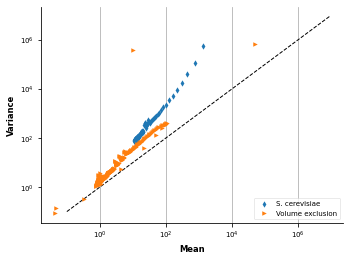

In [3]:
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams["axes.labelsize"] = "small"
matplotlib.rcParams["xtick.labelsize"] = "x-small"
matplotlib.rcParams["ytick.labelsize"] = "x-small"

markers = ["d", ">", ".", "8", "*"]
filenames = [#"../../../data/sexton2012/all_10000_raw.matrix",
             "./data/duan2009/duan.SC.10000.raw.matrix",
             "./data/scerevisiaeve2015/counts.matrix",
             ]

legends = [#"D. melanogaster",
           #"A. thaliana",
           #"H. sapiens",
           "S. cerevisiae",
           "Volume exclusion"]

widerange = np.exp(np.arange(np.log(1e-1), np.log(1e7), 0.01))
fig, ax = plt.subplots()
fig.subplots_adjust(left=0.2, top=0.95, bottom=0.2)
legend_markers = []
for i, filename in enumerate(filenames):
    normalize = True
    if "scerevisiaeve2015" in filename:
        normalize=False
    counts, normed, lengths, bias = load(
        filename, normalize=normalize)
    _, mean, var, _ = dispersion.compute_mean_variance(
        counts,
        lengths,
        bias=bias)
    if "rao" in filename:
        zorder = 5
    else:
        zorder = 10
    s = ax.scatter(mean, var, linewidth=0, marker=markers[i],
                   s=20, zorder=zorder)
    legend_markers.append(s)

ax.set_xscale("log")
ax.set_yscale("log")

le = ax.legend(legend_markers, legends, loc=4, fontsize="x-small")
ax.set_xlabel(r"Mean", fontsize="small", fontweight="bold")
ax.set_ylabel(r"Variance", fontsize="small", fontweight="bold")

ax.plot(np.arange(1e-1, 1e7, 1e6),
        np.arange(1e-1, 1e7, 1e6),
        linewidth=1,
        linestyle="--", color=(0, 0, 0))

ax.grid("off")
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.grid(which="major", axis="y", linewidth=0.75, linestyle="-",
        color="0.7")
f = le.get_frame()
f.set_linewidth(0.5)

